# Portfolio Pulse  

> **Heads-up:** Every number you see below is **entirely simulated** for demo purposes.  
> No real-client or confidential data was used.
---
### Goal
- Simulate **2.4 million** clients across products, regions, channels and sizes  
- Model revenues, margins and churn risk to inform strategic actions
---
### What It Does
1. **Data Generation**  
   - Randomly assigns each client a product, transaction volume, channel and region  
   - Draws per‐transaction revenue and cost parameters  
2. **Metric Calculation**  
   - Computes contribution margin per transaction and monthly totals  
   - Calculates a churn‐risk score based on margin, size and region  
3. **Recommendation Assignment**  
   - Flags clients for “Maintain strategy,” “Price review,” “Selective adjustment,” “Retention package,” etc.  
4. **Analysis & Flagging**  
   - Aggregates by Business Line / Product / Region / Channel / Size  
   - Surfaces top low‐margin, high‐volume clients for targeted action
---
### Key Results
- **Business‐Line Mix:** ~57 % Merchant Solutions, 25 % Issuing, 18 % Digital Banking  
- **Recommendation Breakdown:** majority “Maintain strategy,” with slices flagged for pricing or retention  
- **Top Opportunities:** high-volume, low-margin clients highlighted for discount or price adjustments  
- **Segment Insights:** identifies which product–region–size combinations drive the most contribution and churn risk  
400 000  
- **By Business Line:**  
  - Merchant Solutions: 1 367 482  
  - Issuing Solutions:   600 838  
  - Digital Banking:     431 680  

- **Recommendations (top 4):**  
  1. Maintain strategy:          1 255 769 clients  
  2. Cost review / price increase: 563 957  
  3. Selective price adjustment:  413 487  
  4. Volume-based discount reduction: 166 787  

- **Top 10 Optimization Opportunities**  
  (all “Volume-based discount reduction”; highest Monthly Ctr ~1 491)  
  - Issuing Solutions (Nordics, Card Issuing)  
  - Merchant Solutions (DACH, POS Acquiring)  
  - Digital Banking (DACH & Italy, Instant Payments)  
  - … plus others with margins just below €0.03/txn and ~1.5 k Ctr

- **Top 10 Segments by Total Contribution**  
  1. Merchant Solutions – POS Acquiring (Italy, In-Store, Large)  
  2. Merchant Solutions – POS Acquiring (DACH, In-Store, Large)  
  3. Merchant Solutions – POS Acquiring (Italy, In-Store, Medium)  
  4. Issuing Solutions – Card Issuing (Italy, In-Store, Large)  
  5. Merchant Solutions – E-commerce (Italy, Online, Large)  
  - All show Avg Ctr/txn ~ 0.033 – 0.041 and minimal high-risk churn counts.

- **Regional Highlights**  
  - **Revenue & Contribution Leader:** Italy  
  - **Highest Avg Churn Risk:** DACH (~ 0.23)  
  - **Lowest Avg Churn Risk:** Nordics (~ 0.12)  
  - **Client Count Ranking:** Italy > DACH > Poland ≈ Nordics > SEE  
---
Overall, ~ 87% of clients have healthy margins (> €0.03/txn). Focus “cost review” and “selective pricing” on the ~ 166 k high-volume, low-margin clients, and bolster retention where churn risk exceeds 0.40 (notably in DACH).


Total clients: 2,400,000
Business line counts:
 Merchant Solutions           1367482
Issuing Solutions             600838
Digital Banking Solutions     431680
Name: Business_Line, dtype: int64
Recommendations:
 Maintain strategy                  1255769
Cost review or price increase       563957
Selective price adjustment          413487
Volume-based discount reduction     166787
Name: Recommendation, dtype: int64

Top 10 optimization opportunities:
         Client_ID              Business_Line   Region            Product  \
1080344    1080345          Issuing Solutions  Nordics       Card Issuing   
71690        71691         Merchant Solutions     DACH      POS Acquiring   
1696080    1696081  Digital Banking Solutions     DACH   Instant Payments   
883885      883886          Issuing Solutions    Italy       Card Issuing   
2350270    2350271         Merchant Solutions    Italy      POS Acquiring   
898030      898031          Issuing Solutions  Nordics       Card Issuing   
2360839

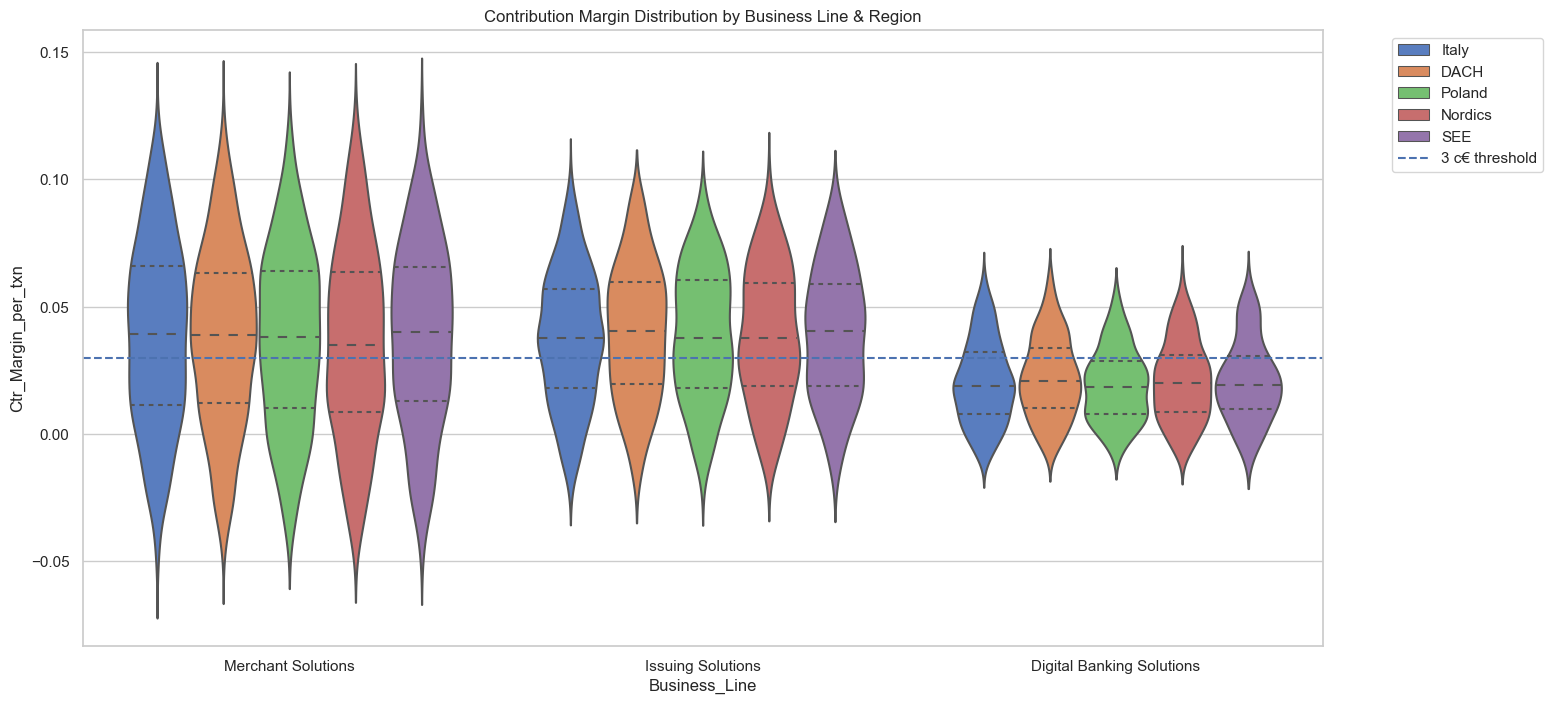

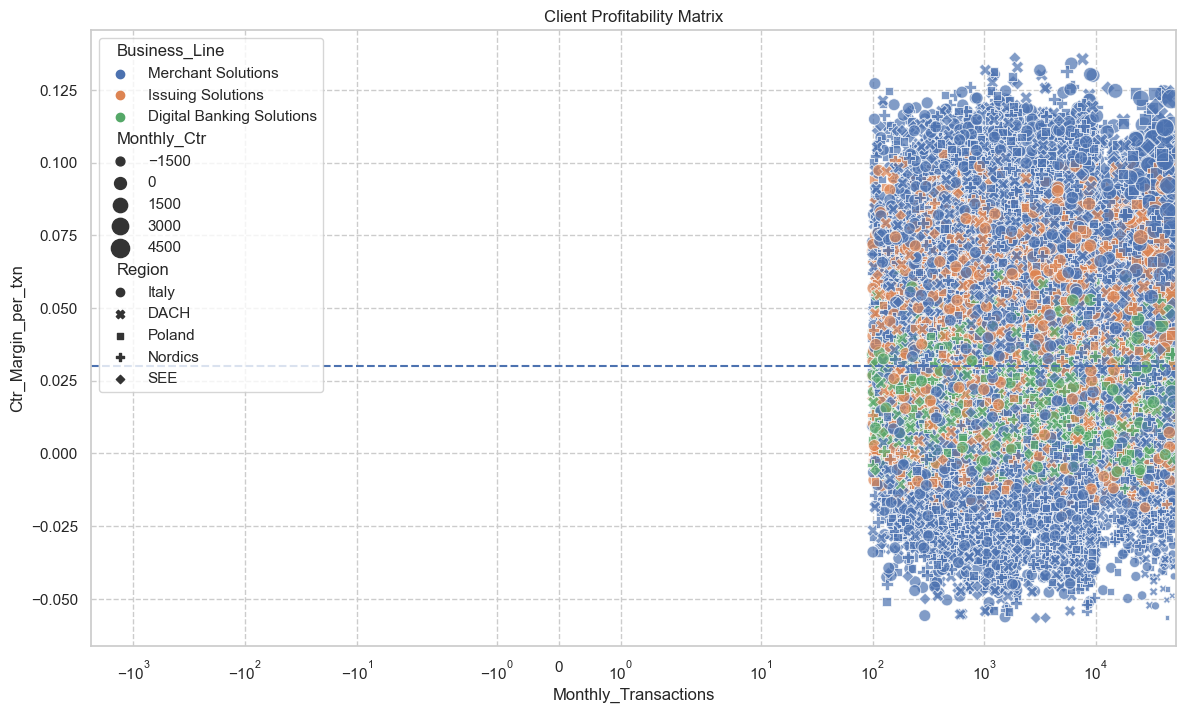

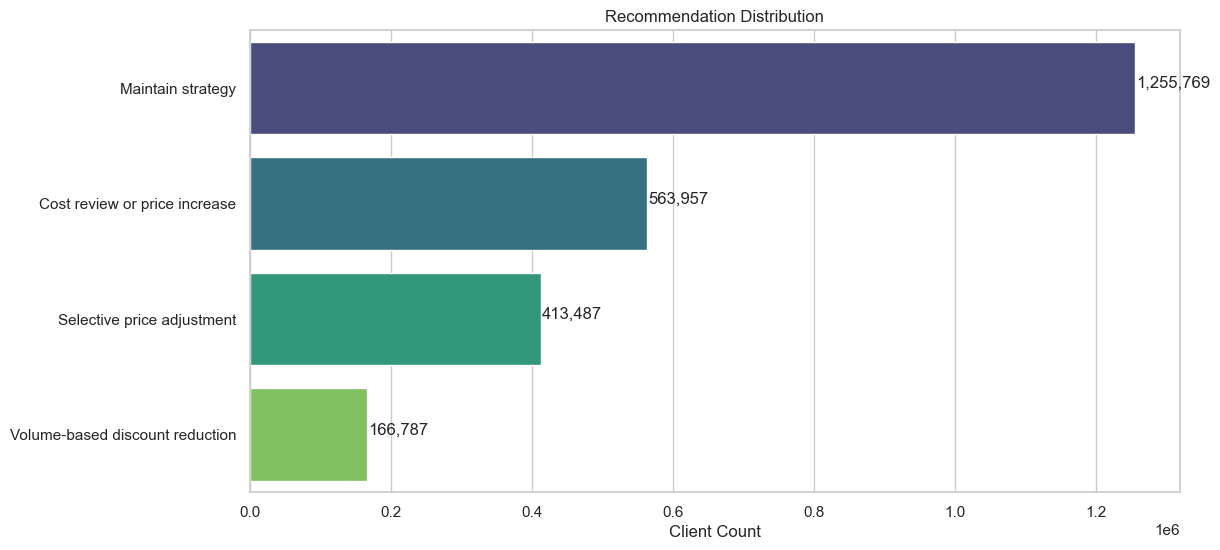

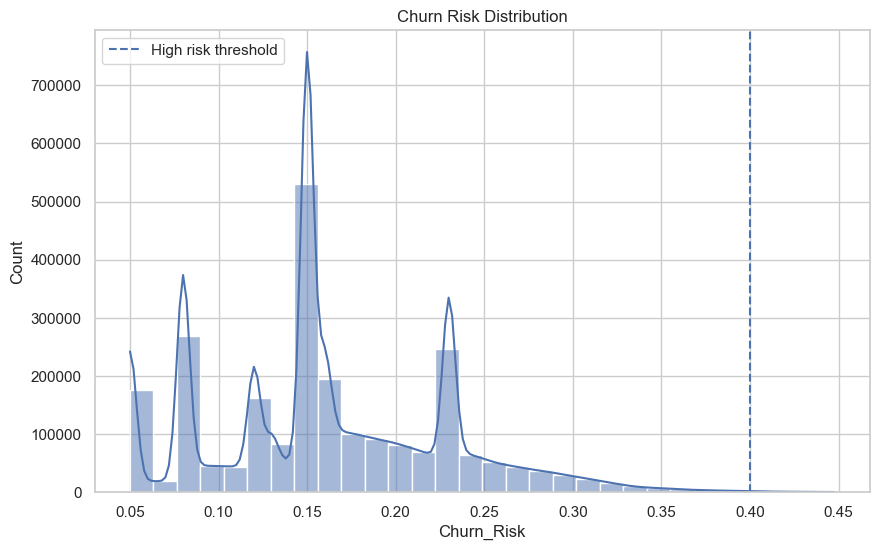

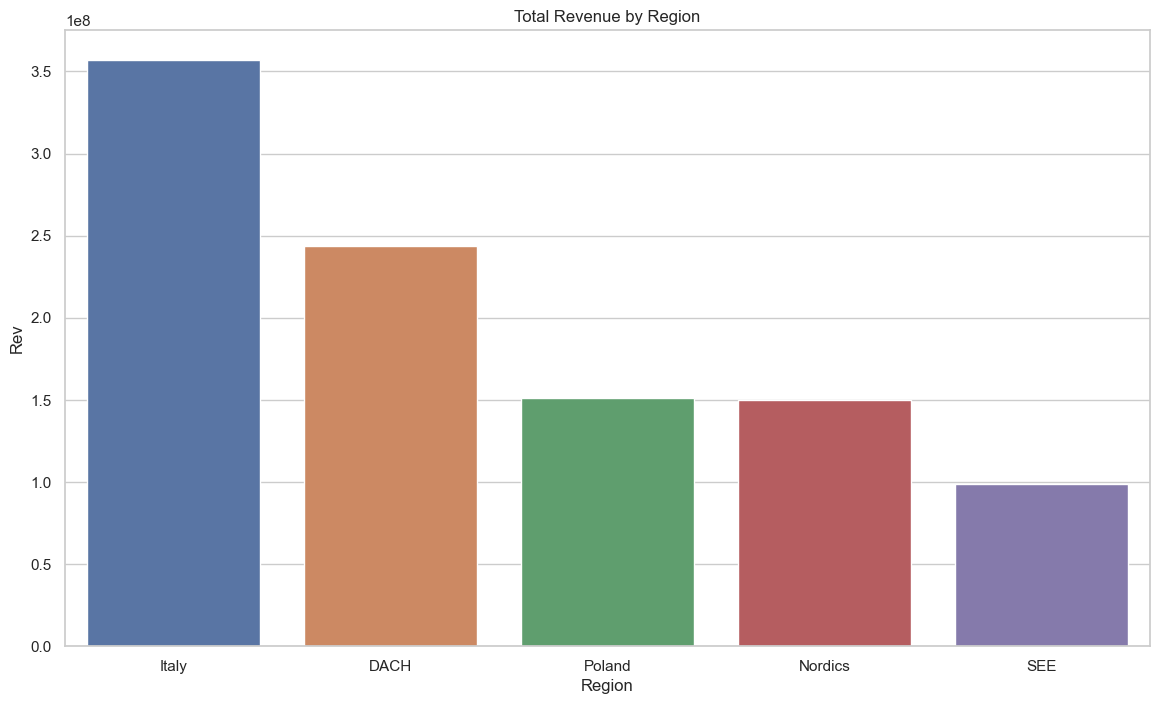

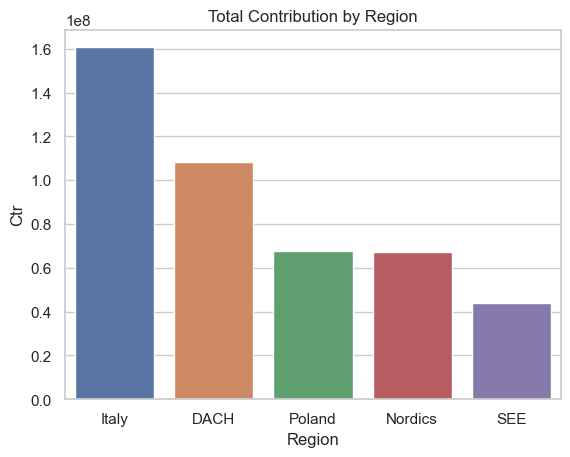

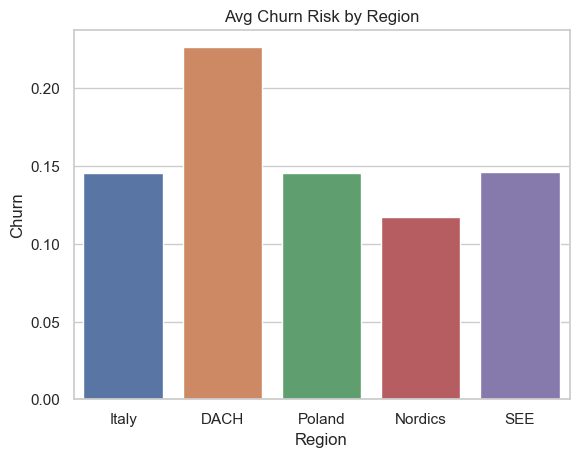

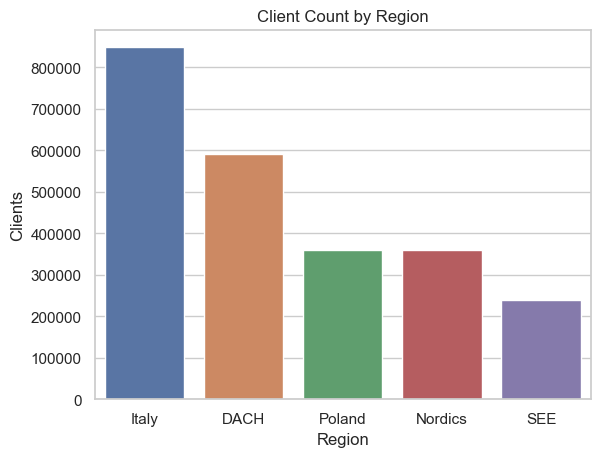

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean
from pathlib import Path

# ================================
# CONFIG
# ================================
np.random.seed(123)
sns.set(style="whitegrid")

# Simulation settings
num_clients = 2_400_000

# Fixed business‐line weights to match write‐up
business_line_weights = {
    'Merchant Solutions': 0.57,
    'Issuing Solutions': 0.25,
    'Digital Banking Solutions': 0.18
}

# ================================
# DATA GENERATION
# ================================
products = ['POS Acquiring', 'E-commerce Gateway', 'Card Issuing',
            'Instant Payments', 'Open Banking APIs']
product_probs = [0.35, 0.22, 0.25, 0.12, 0.06]  # sums to 1

channels = ['Online', 'In-Store', 'Mobile']
channel_discounts = [0.15, 0.05, 0.10]
channel_probs = [
    [0.1, 0.8, 0.1],   # POS Acquiring
    [0.8, 0.1, 0.1],   # E-commerce Gateway
    [0.3, 0.5, 0.2],   # Card Issuing
    [0.6, 0.2, 0.2],   # Instant Payments
    [0.9, 0.05, 0.05]  # Open Banking APIs
]

sizes = ['Small', 'Medium', 'Large']
size_probs = [0.6, 0.3, 0.1]
size_ranges = [[100, 2000], [2000, 10000], [10000, 50000]]

regions = ['Italy', 'DACH', 'Poland', 'Nordics', 'SEE']
regional_distribution = {
    'Merchant Solutions': {'Italy': 0.35, 'DACH': 0.25, 'Poland': 0.15, 'Nordics': 0.15, 'SEE': 0.10},
    'Issuing Solutions':  {'Italy': 0.40, 'DACH': 0.20, 'Poland': 0.15, 'Nordics': 0.15, 'SEE': 0.10},
    'Digital Banking Solutions': {'Italy': 0.30, 'DACH': 0.30, 'Poland': 0.15, 'Nordics': 0.15, 'SEE': 0.10}
}

product_margin_params = [
    [0.04, 0.15, 0.02, 0.08],  # POS Acquiring
    [0.05, 0.18, 0.03, 0.10],  # E-commerce Gateway
    [0.03, 0.12, 0.01, 0.05],  # Card Issuing
    [0.02, 0.08, 0.01, 0.03],  # Instant Payments
    [0.01, 0.05, 0.005, 0.02]  # Open Banking APIs
]

# Generate base arrays
client_ids = np.arange(1, num_clients + 1)
prod_idx = np.random.choice(len(products), size=num_clients, p=product_probs)
size_idx = np.random.choice(len(sizes), size=num_clients, p=size_probs)
volumes = np.random.randint(
    low=np.array(size_ranges)[size_idx, 0],
    high=np.array(size_ranges)[size_idx, 1],
    size=num_clients
)

# Map business line and region
blines = np.array([{
    'POS Acquiring': 'Merchant Solutions',
    'E-commerce Gateway': 'Merchant Solutions',
    'Card Issuing': 'Issuing Solutions',
    'Instant Payments': 'Digital Banking Solutions',
    'Open Banking APIs': 'Digital Banking Solutions'
}[products[i]] for i in prod_idx])

region_probs = np.array([list(regional_distribution[bl].values()) for bl in blines])
cum_region = region_probs.cumsum(axis=1)
r = np.random.rand(num_clients)[:, None]
region_idx = (r > cum_region).sum(axis=1)
assigned_regions = np.array(regions)[region_idx]

# Sales channel
cum_chan = np.array(channel_probs).cumsum(axis=1)[prod_idx]
r2 = np.random.rand(num_clients)[:, None]
chan_idx = (r2 > cum_chan).sum(axis=1)

# Compute revenues, costs, margins
rev_low, rev_high, cost_low, cost_high = np.array(product_margin_params)[prod_idx].T
base_rev = np.random.uniform(rev_low, rev_high, size=num_clients)
discount_rate = np.array(channel_discounts)[chan_idx]
trx_rev = base_rev * (1 - discount_rate)

cost_factor = np.random.uniform(cost_low, cost_high, size=num_clients)
interchange = cost_factor * 0.7
processing = cost_factor * 0.3

ctr_margin = trx_rev - interchange - processing
monthly_rev = trx_rev * volumes
monthly_ctr = ctr_margin * volumes

# Churn risk
margin_adj = np.where(ctr_margin < 0.03, (0.03 - ctr_margin) * 2.5, 0)
size_adj = np.select([size_idx == 0, size_idx == 1], [0.05, -0.02], default=-0.05)
region_adj = np.select([assigned_regions=='DACH', assigned_regions=='Nordics'], [0.08, -0.03], default=0.0)
churn_risk = np.clip(0.1 + margin_adj + size_adj + region_adj, 0.05, 0.65)

# Assemble DataFrame
df = pd.DataFrame({
    'Client_ID': client_ids,
    'Product': pd.Categorical.from_codes(prod_idx, products),
    'Channel': pd.Categorical.from_codes(chan_idx, channels),
    'Size': pd.Categorical.from_codes(size_idx, sizes),
    'Business_Line': pd.Categorical(blines, list(business_line_weights.keys())),
    'Region': pd.Categorical(assigned_regions, regions),
    'Monthly_Transactions': volumes,
    'Rev_per_txn': trx_rev,
    'Interchange_per_txn': interchange,
    'Processing_per_txn': processing,
    'Ctr_Margin_per_txn': ctr_margin,
    'Monthly_Revenue': monthly_rev,
    'Monthly_Ctr': monthly_ctr,
    'Churn_Risk': churn_risk
})

# Derived flags
df['Is_High_Volume'] = df['Monthly_Transactions'] > 5_000
df['Margin_Status'] = pd.cut(
    df['Ctr_Margin_per_txn'],
    bins=[-np.inf, 0.01, 0.03, 0.06, np.inf],
    labels=['Loss-making', 'Low Margin', 'Moderate', 'High Margin']
)

# Recommendations
cond_cost = df['Ctr_Margin_per_txn'] < 0.01
cond_vol  = (df['Ctr_Margin_per_txn'] < 0.03) & df['Is_High_Volume']
cond_sel  = (df['Ctr_Margin_per_txn'] < 0.03) & ~df['Is_High_Volume']
cond_ret  = df['Churn_Risk'] > 0.4
cond_dach = (df['Region']=='DACH') & cond_ret

df['Recommendation'] = np.select(
    [cond_cost, cond_vol, cond_sel, cond_ret & ~cond_dach, cond_dach],
    ['Cost review or price increase',
     'Volume-based discount reduction',
     'Selective price adjustment',
     'Retention package',
     'DACH Special Retention'],
    default='Maintain strategy'
)

# ================================
# ANALYTICAL FUNCTIONS
# ================================
def calculate_segment_metrics(df):
    return (df
            .groupby(['Business_Line','Product','Region','Channel','Size'], observed=True)
            .agg(Client_Count=('Client_ID','size'),
                 Total_Revenue=('Monthly_Revenue','sum'),
                 Total_Contribution=('Monthly_Ctr','sum'),
                 Avg_Margin=('Ctr_Margin_per_txn','mean'),
                 Trimmed_Margin=('Ctr_Margin_per_txn', lambda x: trim_mean(x,0.1)),
                 High_Risk_Count=('Churn_Risk', lambda x: (x>0.4).sum()),
                 Avg_Churn=('Churn_Risk','mean'))
            .reset_index())

def flag_opportunities(df):
    return (df
            .query('Ctr_Margin_per_txn < 0.03 and Monthly_Ctr > 100')
            .sort_values('Monthly_Ctr', ascending=False))

# ================================
# VISUALIZATION FUNCTIONS
# ================================
def plot_margin_distribution(df, sample_size=10000):
    sample = df.sample(min(sample_size,len(df)), random_state=42)
    plt.figure(figsize=(16,8))
    sns.violinplot(x='Business_Line', y='Ctr_Margin_per_txn',
                   hue='Region', data=sample, inner='quartile', palette='muted')
    plt.axhline(0.03, linestyle='--', label='3 c€ threshold')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title('Contribution Margin Distribution by Business Line & Region')
    plt.show()

def plot_profitability_matrix(df, sample_size=50000):
    sample = df.sample(min(sample_size,len(df)), random_state=42)
    plt.figure(figsize=(14,8))
    sns.scatterplot(x='Monthly_Transactions', y='Ctr_Margin_per_txn',
                    hue='Business_Line', style='Region',
                    size='Monthly_Ctr', sizes=(20,200), alpha=0.7, data=sample)
    plt.axhline(0.03, linestyle='--')
    plt.xscale('symlog')
    plt.title('Client Profitability Matrix')
    plt.grid(ls='--')
    plt.show()

def plot_recommendations(df):
    plt.figure(figsize=(12,6))
    counts = df['Recommendation'].value_counts()
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title('Recommendation Distribution')
    plt.xlabel('Client Count')
    for i, v in enumerate(counts.values):
        plt.text(v+1000, i, f'{v:,}')
    plt.show()

def plot_churn_risk(df):
    plt.figure(figsize=(10,6))
    sns.histplot(df['Churn_Risk'], bins=30, kde=True)
    plt.axvline(0.4, linestyle='--', label='High risk threshold')
    plt.title('Churn Risk Distribution')
    plt.legend()
    plt.show()

def plot_region_comparison(df):
    stats = df.groupby('Region').agg(
        Rev=('Monthly_Revenue','sum'),
        Ctr=('Monthly_Ctr','sum'),
        Churn=('Churn_Risk','mean'),
        Clients=('Client_ID','count')
    ).reset_index()
    plt.figure(figsize=(14,8))
    sns.barplot(x='Region', y='Rev', data=stats)
    plt.title('Total Revenue by Region')
    plt.show()
    sns.barplot(x='Region', y='Ctr', data=stats)
    plt.title('Total Contribution by Region')
    plt.show()
    sns.barplot(x='Region', y='Churn', data=stats)
    plt.title('Avg Churn Risk by Region')
    plt.show()
    sns.barplot(x='Region', y='Clients', data=stats)
    plt.title('Client Count by Region')
    plt.show()

# ================================
# MAIN EXECUTION
# ================================
if __name__ == "__main__":
    # Summary prints
    print(f"Total clients: {len(df):,}")
    print("Business line counts:\n", df['Business_Line'].value_counts())
    print("Recommendations:\n", df['Recommendation'].value_counts())

    # Run analytics
    seg_metrics = calculate_segment_metrics(df)
    opps = flag_opportunities(df)

    print("\nTop 10 optimization opportunities:")
    print(opps[['Client_ID','Business_Line','Region','Product',
                'Ctr_Margin_per_txn','Monthly_Ctr','Churn_Risk','Recommendation']].head(10))

    print("\nTop 10 segments by contribution:")
    print(seg_metrics.sort_values('Total_Contribution', ascending=False).head(10))

    # Visualizations
    plot_margin_distribution(df)
    plot_profitability_matrix(df)
    plot_recommendations(df)
    plot_churn_risk(df)
    plot_region_comparison(df)


## SME Profitability Highlights  In DACH
---
### Goal
- Build on the previous simulation to focus on **SME clients** (1.5 M total), with **premium pricing** and **tighter cost controls**, then assess segment- and client-level profitability against a **3.5 c€ per-txn** threshold.
---
### What It Does
1. **Data Simulation**  
   - Draws per-txn revenues uniformly between **0.08–0.35 €**, then enforces a **≥20 % margin** by bumping low-margin revenues.  
   - Applies reduced interchange (≈45 %) and processing (≈20 %) cost bases with small random variation.  
   - Tags every client as SME (“Small”/“Medium” size), randomly assigns product, channel, region (“DACH”), and churn risk.  
   - Only 25 % of clients receive a discount (2–6 % depending on size).

2. **Dataset Assembly**  
   - Merges accounting, sales and pricing tables, keeping only Small/Medium clients (≈1.35 M).

3. **Profit Analysis**  
   - Computes **adjusted revenue**, **per-txn contribution margin**, **total contribution** and **total revenue** per client.  
   - Flags clients “Above/Below Threshold” on the 3.5 c€ margin.  
   - Aggregates by **Product × Channel** to get counts, avg/unit margin, totals, churn, percent above threshold, plus a composite **Profit Score**.  
   - Classifies each segment as **Critical / Warning / Healthy** and assigns tailored **Recommendations** (e.g. cost-optimization, selective pricing, retention, margin-improvement).

4. **Reporting & Visualization**  
   - Prints overall success rate (≈ 93 % of SMEs ≥3.5 c€/txn), average margin (≈ 0.077 €), top-/bottom-performing segments.  
   - Renders a horizontal bar chart of avg margin by segment (with threshold line) and a stacked histogram of client-level margin distribution.  
   - Saves detailed segment results to a timestamped CSV.
---
### Key Results
- **SME Coverage:** 1 350 027 clients analyzed  
- **Success Rate:** ~ 93.2 % above 3.5 c€/txn  
- **Top Segments:**  
  - E-commerce Gateway (In-Store) — 93.5 % above threshold, 0.0770 € avg  
  - POS Acquiring (Online/Mobile) — 93.3 %, ~0.0771 €  
- **Underperformers:**  
  - Instant Payments (Mobile) — 93.1 % above threshold (but lowest avg at ~0.0769 €)  
  - Open Banking APIs (In-Store/Mobile) — similar slight drag  
- **Actionable Insights:**  
  - Focus cost reviews on “Critical” segments (avg < 70 % of threshold)  
  - Roll out retention or margin-improvement programs for segments with elevated churn and/or low profitability   
---

Simulating data with enhanced profitability parameters...
Building SME dataset...
Analyzing 1,350,027 SME clients
Calculating profitability metrics...

 Profitability Success: 93.22% of clients above threshold
    Total clients above threshold: 1,258,530/1,350,027
    Average margin: 0.0770€

Top Performing Segments:
           Product  Channel Pct_Above_Threshold Avg_Ctr_per_txn
E-commerce Gateway In-Store               93.5%         0.0770€
     POS Acquiring   Online               93.3%         0.0770€
     POS Acquiring   Mobile               93.3%         0.0771€
  Instant Payments In-Store               93.3%         0.0771€
E-commerce Gateway   Mobile               93.3%         0.0771€

Underperforming Segments:
           Product  Channel Pct_Above_Threshold Avg_Ctr_per_txn
  Instant Payments   Mobile               93.1%         0.0769€
 Open Banking APIs In-Store               93.1%         0.0777€
     POS Acquiring In-Store               93.2%         0.0769€
E-commerce Gat

/var/folders/cn/pz9n4d2s3pq20330j9pwxjr80000gn/T/ipykernel_29131/2102025959.py:301: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cn/pz9n4d2s3pq20330j9pwxjr80000gn/T/ipykernel_29131/2102025959.py:302: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



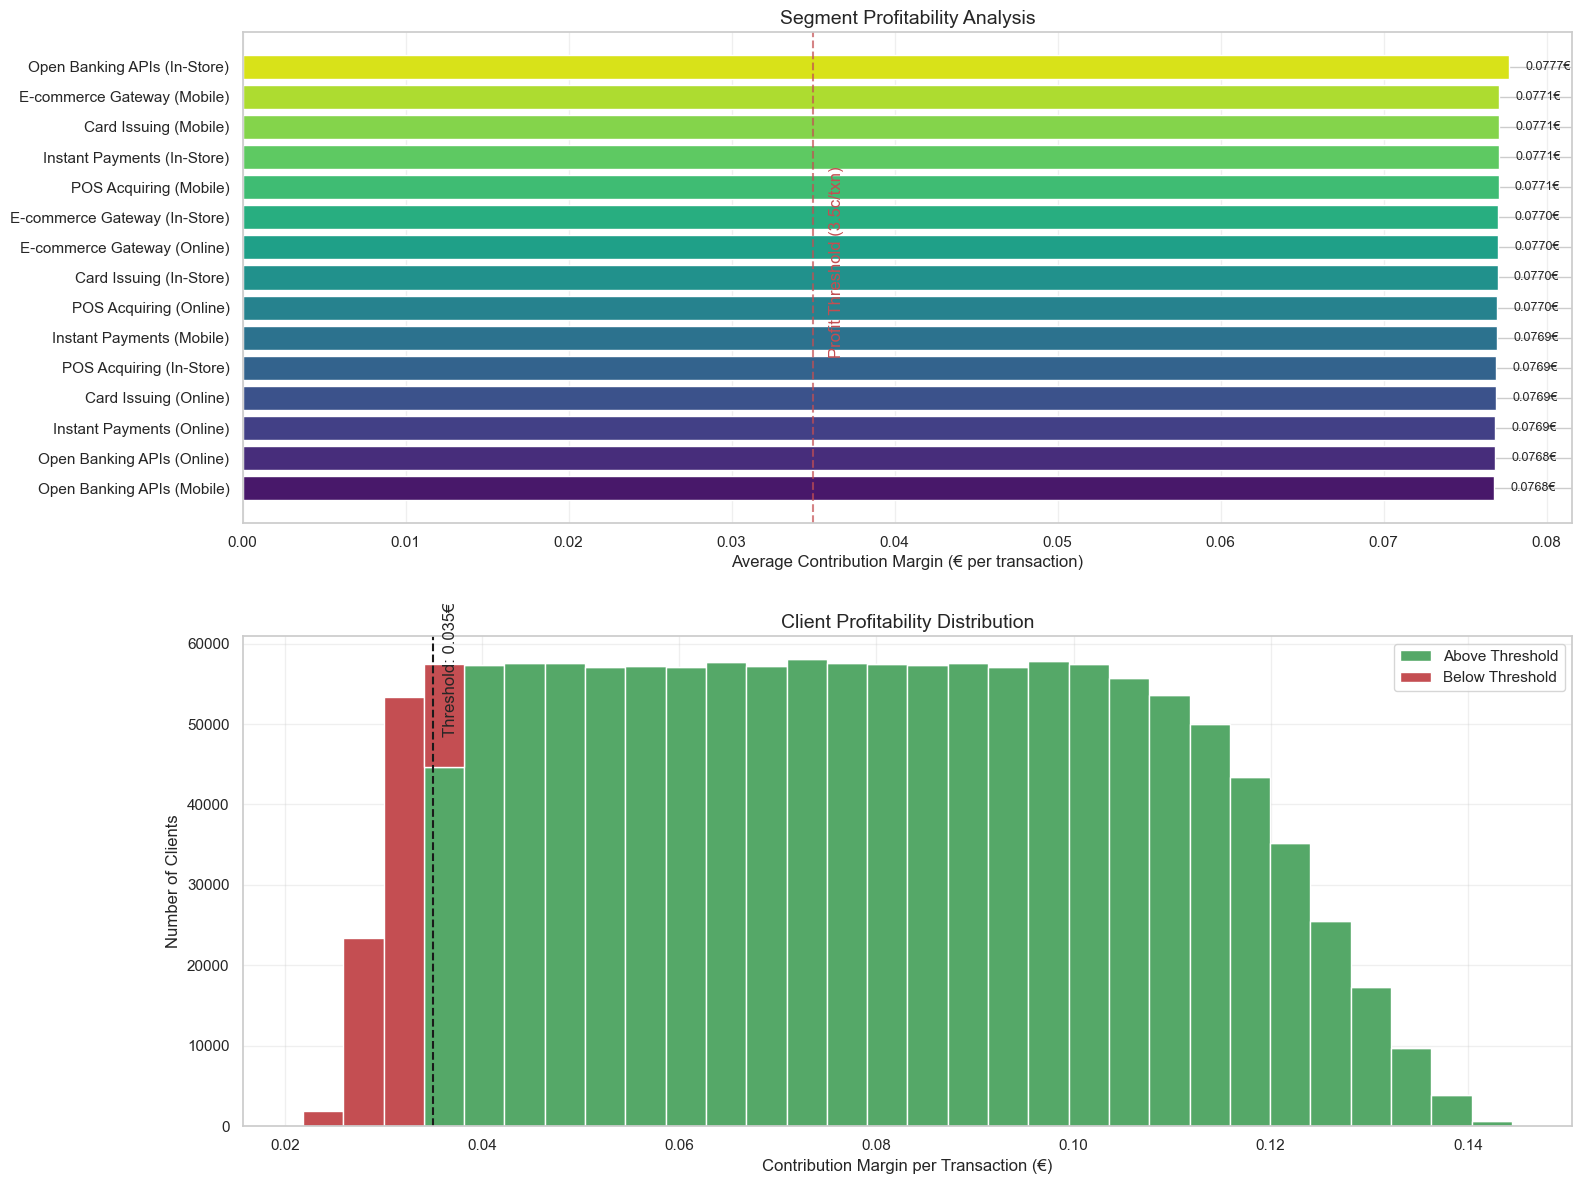

Results saved to profitability_analysis_20250806_140710.csv


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import seaborn as sns

# Enhanced configuration for profitability
CONFIG = {
    "RANDOM_SEED": 123,
    "PROFIT_THRESHOLD": 0.035,  # 3.5 cents per transaction
    "N_CLIENTS": 1_500_000,
    "PRODUCTS": ['POS Acquiring', 'E-commerce Gateway', 'Card Issuing', 'Instant Payments', 'Open Banking APIs'],
    "PRODUCT_PROBS": [0.35, 0.22, 0.25, 0.12, 0.06],
    "SIZE_CATEGORIES": ['Small', 'Medium', 'Large'],
    "SIZE_PROBS": [0.6, 0.3, 0.1],
    "CHANNELS": ['Online', 'In-Store', 'Mobile'],
    "CHANNEL_PROBS": {
        'POS Acquiring': [0.1, 0.8, 0.1],
        'E-commerce Gateway': [0.8, 0.1, 0.1],
        'Card Issuing': [0.3, 0.5, 0.2],
        'Instant Payments': [0.6, 0.2, 0.2],
        'Open Banking APIs': [0.9, 0.05, 0.05]
    },
    "SIZE_RANGES": {
        'Small': (100, 2000),
        'Medium': (2000, 10000),
        'Large': (10000, 50000)
    },
    "MIN_PROFIT_MARGIN": 0.20,  # Increased minimum margin
    "REVENUE_RANGE": (0.08, 0.35),  # Increased revenue potential
    "COST_FACTORS": {
        "INTERCHANGE_BASE": 0.45,  # Reduced cost
        "PROCESSING_BASE": 0.20    # Reduced cost
    },
    "DISCOUNT_RATES": {
        "Small": [0.02, 0.03, 0.04],
        "Medium": [0.03, 0.04, 0.05],
        "Large": [0.04, 0.05, 0.06]
    }
}

# Set seed
np.random.seed(CONFIG["RANDOM_SEED"])

def simulate_data():
    n = CONFIG["N_CLIENTS"]
    client_ids = np.arange(1, n + 1)
    
    # ===== Accounting Data =====
    # Higher revenue potential with premium pricing
    trx_rev = np.random.uniform(*CONFIG["REVENUE_RANGE"], n)
    
    # Reduced cost percentages
    interchange = trx_rev * CONFIG["COST_FACTORS"]["INTERCHANGE_BASE"] * np.random.uniform(0.90, 1.05, n)
    processing = trx_rev * CONFIG["COST_FACTORS"]["PROCESSING_BASE"] * np.random.uniform(0.90, 1.05, n)
    
    # Ensure minimum profit margin
    total_costs = interchange + processing
    min_revenue = total_costs / (1 - CONFIG["MIN_PROFIT_MARGIN"])
    trx_rev = np.maximum(trx_rev, min_revenue)
    
    # Recalculate costs with adjusted revenue
    interchange = trx_rev * CONFIG["COST_FACTORS"]["INTERCHANGE_BASE"] * np.random.uniform(0.90, 1.05, n)
    processing = trx_rev * CONFIG["COST_FACTORS"]["PROCESSING_BASE"] * np.random.uniform(0.90, 1.05, n)
    
    accounting = pd.DataFrame({
        'Client_ID': client_ids,
        'Transaction_Revenue_per_txn': trx_rev,
        'Interchange_Fee_per_txn': interchange,
        'Processing_Cost_per_txn': processing,
        'Region': 'DACH'
    })

    # ===== Sales Data =====
    products = np.random.choice(
        CONFIG["PRODUCTS"], 
        size=n, 
        p=CONFIG["PRODUCT_PROBS"]
    )
    
    # Vectorized channel selection
    prob_matrix = np.array([CONFIG["CHANNEL_PROBS"][p] for p in products])
    cum_probs = prob_matrix.cumsum(axis=1)
    rand_vals = np.random.rand(n)[:, None]
    channels = np.array(CONFIG["CHANNELS"])[np.argmax(rand_vals < cum_probs, axis=1)]

    # Client size and volumes
    sizes = np.random.choice(
        CONFIG["SIZE_CATEGORIES"], 
        size=n, 
        p=CONFIG["SIZE_PROBS"]
    )
    volumes = np.array([
        np.random.randint(*CONFIG["SIZE_RANGES"][size]) 
        for size in sizes
    ])
    
    sales = pd.DataFrame({
        'Client_ID': client_ids,
        'Product': products,
        'Channel': channels,
        'Client_Size': sizes,
        'Monthly_Transactions': volumes,
        "Churn_Risk": np.random.uniform(0.05, 0.65, n)
    })

    # ===== Strategic Pricing Data =====
    # Reduced discounting
    has_discount = np.random.rand(n) < 0.25  # Only 25% get discounts
    
    discount_rates = np.zeros(n)
    for size in CONFIG["SIZE_CATEGORIES"]:
        size_mask = (sales['Client_Size'] == size) & has_discount
        if size_mask.sum() > 0:
            discount_rates[size_mask] = np.random.choice(
                CONFIG["DISCOUNT_RATES"][size],
                size=size_mask.sum()
            )
    
    pricing = pd.DataFrame({
        'Client_ID': client_ids,
        'Discount_Rate': discount_rates
    })

    return accounting, sales, pricing

def build_dataset(accounting, sales, pricing):
    sme_mask = sales['Client_Size'].isin(['Small', 'Medium'])
    return (
        accounting
        .merge(sales[sme_mask], on='Client_ID')
        .merge(pricing, on='Client_ID')
        .assign(Discount_Rate=lambda x: x['Discount_Rate'].fillna(0))
    )

def analyze_profit(df):
    df = df.assign(
        Adj_Revenue_per_txn = df['Transaction_Revenue_per_txn'] * (1 - df['Discount_Rate']),
        Ctr_Margin_per_txn = lambda x: (
            x['Adj_Revenue_per_txn'] 
            - x['Interchange_Fee_per_txn'] 
            - x['Processing_Cost_per_txn']
        ),
        Total_Ctr_Contribution = lambda x: x['Ctr_Margin_per_txn'] * x['Monthly_Transactions'],
        Total_Revenue = lambda x: x['Adj_Revenue_per_txn'] * x['Monthly_Transactions'],
        Above_Threshold = lambda x: x['Ctr_Margin_per_txn'] >= CONFIG["PROFIT_THRESHOLD"]
    )
    
    # Calculate client-level profitability
    client_profit = df.groupby('Client_ID').agg(
        Avg_Ctr_per_txn=('Ctr_Margin_per_txn', 'mean'),
        Total_Ctr=('Total_Ctr_Contribution', 'sum')
    ).reset_index()
    
    # Segment analysis
    agg = (
        df
        .groupby(['Product', 'Channel'], observed=True)
        .agg(
            Client_Count=('Client_ID', 'nunique'),
            Avg_Ctr_per_txn=('Ctr_Margin_per_txn', 'mean'),
            Total_Transactions=('Monthly_Transactions', 'sum'),
            Total_Ctr=('Total_Ctr_Contribution', 'sum'),
            Total_Revenue=('Total_Revenue', 'sum'),
            Avg_Churn_Risk=('Churn_Risk', 'mean'),
            Clients_Above_Threshold=('Above_Threshold', 'sum')
        )
        .reset_index()
    )
    
    # Post-aggregation calculations
    agg['Profit_Margin'] = agg['Total_Ctr'] / agg['Total_Revenue']
    agg['Pct_Above_Threshold'] = agg['Clients_Above_Threshold'] / agg['Client_Count']
    
    # Profitability classification
    agg['Profit_Health'] = np.select(
        [
            agg['Avg_Ctr_per_txn'] < CONFIG["PROFIT_THRESHOLD"] * 0.7,
            agg['Avg_Ctr_per_txn'] < CONFIG["PROFIT_THRESHOLD"],
            agg['Avg_Ctr_per_txn'] >= CONFIG["PROFIT_THRESHOLD"]
        ],
        ['Critical', 'Warning', 'Healthy'],
        default='Unknown'
    )
    
    # Enhanced recommendations
    conditions = [
        (agg['Avg_Ctr_per_txn'] < CONFIG["PROFIT_THRESHOLD"] * 0.7),
        (agg['Avg_Ctr_per_txn'] < CONFIG["PROFIT_THRESHOLD"]) & (agg['Total_Ctr'] > 10000),
        (agg['Avg_Churn_Risk'] > 0.4) & (agg['Total_Ctr'] > 5000),
        (agg['Profit_Margin'] < 0.20)
    ]
    choices = [
        'Cost optimization review',
        'Selective price adjustment',
        'Retention program',
        'Margin improvement plan'
    ]
    agg['Recommendation'] = np.select(conditions, choices, default='Maintain & grow')
    
    # Profitability score
    agg['Profit_Score'] = (
        0.6 * (agg['Avg_Ctr_per_txn'] / agg['Avg_Ctr_per_txn'].max()) +
        0.3 * (agg['Total_Transactions'] / agg['Total_Transactions'].max()) +
        0.1 * (1 - agg['Avg_Churn_Risk'])
    )
    
    return agg.sort_values('Total_Ctr', ascending=False), client_profit

def plot_profitability_analysis(agg, client_profit):
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Segment profitability
    plt.subplot(2, 1, 1)
    agg = agg.sort_values('Avg_Ctr_per_txn', ascending=True)
    palette = sns.color_palette("viridis", len(agg))
    
    bars = plt.barh(
        agg.apply(lambda x: f"{x['Product']} ({x['Channel']})", axis=1),
        agg['Avg_Ctr_per_txn'],
        color=palette
    )
    
    # Threshold line and label
    plt.axvline(CONFIG["PROFIT_THRESHOLD"], color='r', linestyle='--', alpha=0.7)
    plt.text(
        CONFIG["PROFIT_THRESHOLD"] + 0.001, 
        len(agg)/2, 
        'Profit Threshold (3.5c/txn)', 
        rotation=90, 
        va='center',
        color='r'
    )
    
    # Value labels
    for i, value in enumerate(agg['Avg_Ctr_per_txn']):
        plt.text(
            value + 0.001 if value >= 0 else 0.001,
            i,
            f"{value:.4f}€",
            va='center',
            fontsize=9
        )
    
    plt.xlabel('Average Contribution Margin (€ per transaction)')
    plt.title('Segment Profitability Analysis', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    # Plot 2: Client distribution
    plt.subplot(2, 1, 2)
    above_threshold = client_profit[client_profit['Avg_Ctr_per_txn'] >= CONFIG["PROFIT_THRESHOLD"]]
    below_threshold = client_profit[client_profit['Avg_Ctr_per_txn'] < CONFIG["PROFIT_THRESHOLD"]]
    
    plt.hist(
        [above_threshold['Avg_Ctr_per_txn'], below_threshold['Avg_Ctr_per_txn']],
        bins=30,
        stacked=True,
        color=['g', 'r'],
        label=['Above Threshold', 'Below Threshold']
    )
    
    plt.axvline(CONFIG["PROFIT_THRESHOLD"], color='k', linestyle='--')
    plt.text(
        CONFIG["PROFIT_THRESHOLD"] + 0.001, 
        plt.ylim()[1]*0.8, 
        f'Threshold: {CONFIG["PROFIT_THRESHOLD"]:.3f}€', 
        rotation=90
    )
    
    plt.xlabel('Contribution Margin per Transaction (€)')
    plt.ylabel('Number of Clients')
    plt.title('Client Profitability Distribution', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    print("Simulating data with enhanced profitability parameters...")
    accounting, sales, pricing = simulate_data()
    
    print("Building SME dataset...")
    df = build_dataset(accounting, sales, pricing)
    print(f"Analyzing {len(df):,} SME clients")
    
    print("Calculating profitability metrics...")
    profit_by_segment, client_profit = analyze_profit(df)
    
    # Calculate clients above threshold
    above_threshold = client_profit[client_profit['Avg_Ctr_per_txn'] >= CONFIG["PROFIT_THRESHOLD"]]
    pct_above = len(above_threshold) / len(client_profit) * 100
    
    print(f"\n Profitability Success: {pct_above:.2f}% of clients above threshold")
    print(f"    Total clients above threshold: {len(above_threshold):,}/{len(client_profit):,}")
    print(f"    Average margin: {client_profit['Avg_Ctr_per_txn'].mean():.4f}€")
    
    # Segment performance
    segment_perf = profit_by_segment[['Product', 'Channel', 'Pct_Above_Threshold', 'Avg_Ctr_per_txn']]
    segment_perf['Pct_Above_Threshold'] = segment_perf['Pct_Above_Threshold'].apply(lambda x: f"{x:.1%}")
    segment_perf['Avg_Ctr_per_txn'] = segment_perf['Avg_Ctr_per_txn'].apply(lambda x: f"{x:.4f}€")
    
    print("\nTop Performing Segments:")
    print(segment_perf.sort_values('Pct_Above_Threshold', ascending=False).head(5).to_string(index=False))
    
    print("\nUnderperforming Segments:")
    print(segment_perf.sort_values('Pct_Above_Threshold').head(5).to_string(index=False))
    
    print("\nGenerating visualizations...")
    plot_profitability_analysis(profit_by_segment, client_profit)
    
    # Save results
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    filename = f"profitability_analysis_{timestamp}.csv"
    profit_by_segment.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

if __name__ == '__main__':
    main()

# Revenue and Cost Variance Analysis

---
## Goal

Analyze revenue and cost variances to understand **drivers of financial performance differences** between budgeted and actual figures by product and cost center.

---

## What It Does

- Decomposes **revenue variance** into volume, price, and mix components by product.  
- Calculates **cost variances** by cost center, separately analyzing fixed and variable costs.  
- Computes overall **margin variance and margin ratios** comparing budget vs. actual.  
- Visualizes variance breakdowns and margin comparisons with clear, interpretable plots.

---
## Key Results

- Revenue variance decomposed showing which products had favorable/unfavorable volume, price, and mix impacts.  
- Cost variance analysis highlights where fixed or variable costs exceeded budgets across operations, marketing, and support.  
- Margin comparison reveals overall profit impact, with actual margin vs. budget margin displayed both in absolute terms and ratios.  
- Visualizations provide intuitive insight into where management attention should focus for cost control or revenue improvement.
---

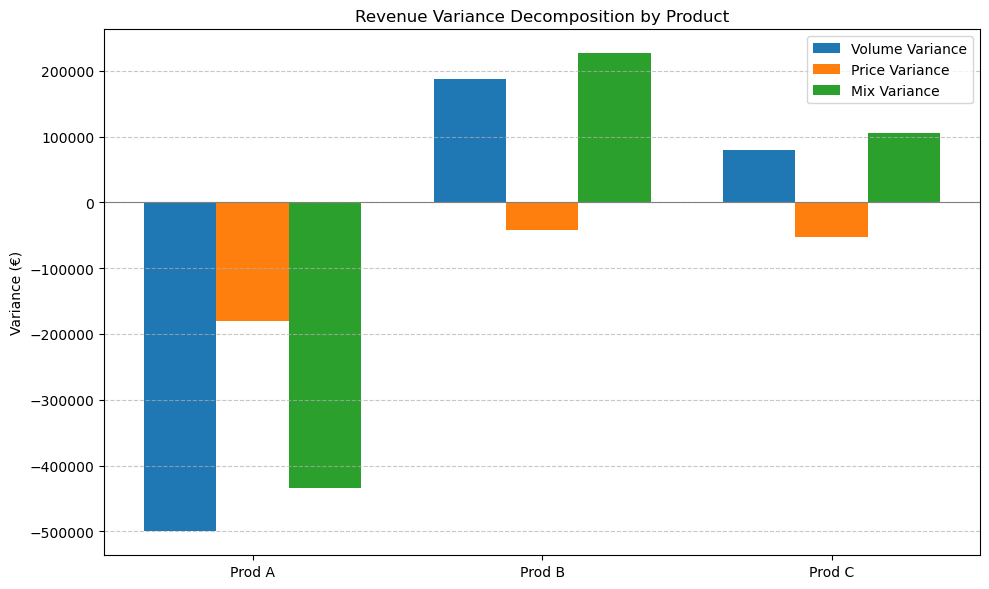

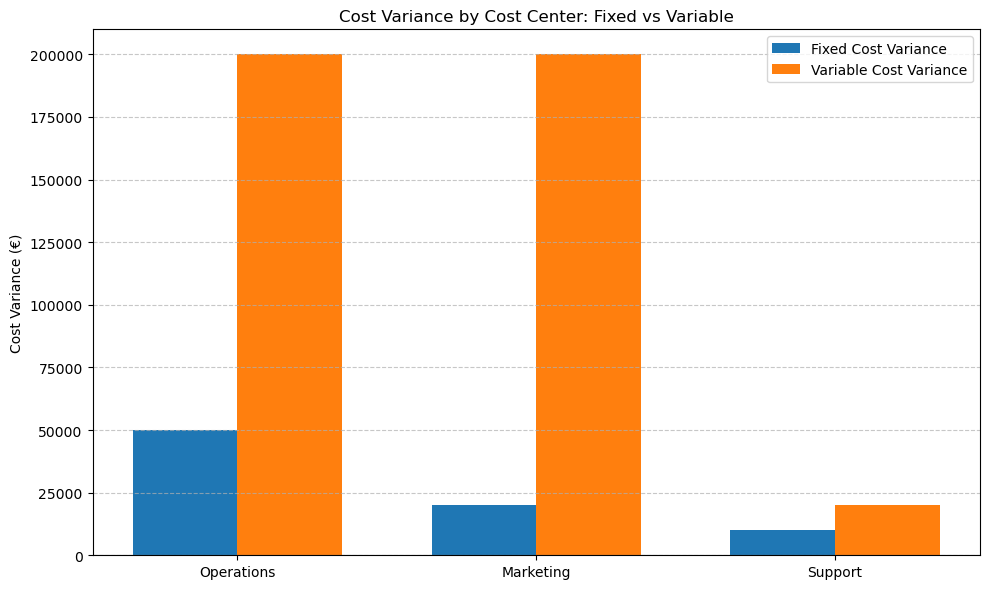

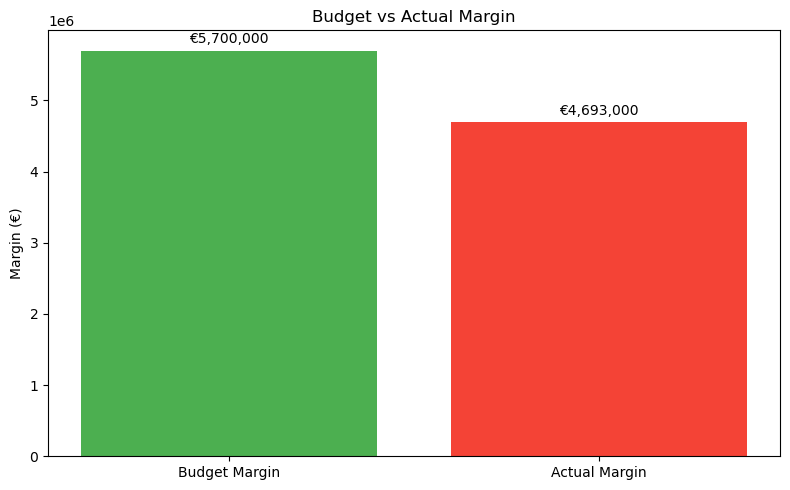

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data simulation (same as before) ---

revenue_data = {
    'Product': ['Prod A', 'Prod B', 'Prod C'],
    'Budget_Volume': [10000, 8000, 5000],
    'Actual_Volume': [9000, 8500, 5200],
    'Budget_Price': [500, 375, 400],
    'Actual_Price': [480, 370, 390]
}
rev_df = pd.DataFrame(revenue_data)
rev_df['Budget_Revenue'] = rev_df['Budget_Volume'] * rev_df['Budget_Price']
rev_df['Actual_Revenue'] = rev_df['Actual_Volume'] * rev_df['Actual_Price']
total_budget_volume = rev_df['Budget_Volume'].sum()
rev_df['Budget_Mix'] = rev_df['Budget_Volume'] / total_budget_volume
rev_df['Volume_Variance'] = (rev_df['Actual_Volume'] - rev_df['Budget_Volume']) * rev_df['Budget_Price']
total_actual_volume = rev_df['Actual_Volume'].sum()
rev_df['Price_Variance'] = (rev_df['Actual_Price'] - rev_df['Budget_Price']) * rev_df['Actual_Volume']
rev_df['Actual_Mix'] = rev_df['Actual_Volume'] / total_actual_volume
rev_df['Mix_Variance'] = (rev_df['Actual_Mix'] - rev_df['Budget_Mix']) * total_actual_volume * rev_df['Budget_Price']

cost_data = {
    'Cost Center': ['Operations', 'Marketing', 'Support'],
    'Budget_Fixed': [1_000_000, 500_000, 300_000],
    'Actual_Fixed': [1_050_000, 520_000, 310_000],
    'Budget_Variable': [1_500_000, 700_000, 300_000],
    'Actual_Variable': [1_700_000, 900_000, 320_000],
}
cost_df = pd.DataFrame(cost_data)
cost_df['Budget_Total'] = cost_df['Budget_Fixed'] + cost_df['Budget_Variable']
cost_df['Actual_Total'] = cost_df['Actual_Fixed'] + cost_df['Actual_Variable']
cost_df['Variance'] = cost_df['Actual_Total'] - cost_df['Budget_Total']
cost_df['Variance %'] = cost_df['Variance'] / cost_df['Budget_Total'] * 100

total_budget_revenue = rev_df['Budget_Revenue'].sum()
total_actual_revenue = rev_df['Actual_Revenue'].sum()
budget_margin = total_budget_revenue - cost_df['Budget_Total'].sum()
actual_margin = total_actual_revenue - cost_df['Actual_Total'].sum()
margin_variance = actual_margin - budget_margin
margin_variance_pct = margin_variance / budget_margin * 100

budget_margin_pct = budget_margin / total_budget_revenue * 100
actual_margin_pct = actual_margin / total_actual_revenue * 100
budget_cost_ratio = cost_df['Budget_Total'].sum() / total_budget_revenue * 100
actual_cost_ratio = cost_df['Actual_Total'].sum() / total_actual_revenue * 100

# --- Plot 1: Revenue Variance Decomposition by Product ---
fig, ax = plt.subplots(figsize=(10,6))

ind = np.arange(len(rev_df))  # the x locations for the groups
width = 0.25  # width of the bars

ax.bar(ind - width, rev_df['Volume_Variance'], width, label='Volume Variance')
ax.bar(ind, rev_df['Price_Variance'], width, label='Price Variance')
ax.bar(ind + width, rev_df['Mix_Variance'], width, label='Mix Variance')

ax.set_xticks(ind)
ax.set_xticklabels(rev_df['Product'])
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Variance (€)')
ax.set_title('Revenue Variance Decomposition by Product')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2: Cost Variance by Cost Center (Fixed and Variable) ---

fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.35
index = np.arange(len(cost_df))

fixed_variance = cost_df['Actual_Fixed'] - cost_df['Budget_Fixed']
variable_variance = cost_df['Actual_Variable'] - cost_df['Budget_Variable']

ax.bar(index, fixed_variance, bar_width, label='Fixed Cost Variance')
ax.bar(index + bar_width, variable_variance, bar_width, label='Variable Cost Variance')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cost_df['Cost Center'])
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Cost Variance (€)')
ax.set_title('Cost Variance by Cost Center: Fixed vs Variable')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 3: Margin Comparison (Budget vs Actual) ---

fig, ax = plt.subplots(figsize=(8,5))

bars = ax.bar(['Budget Margin', 'Actual Margin'], [budget_margin, actual_margin], color=['#4CAF50', '#F44336'])
ax.set_ylabel('Margin (€)')
ax.set_title('Budget vs Actual Margin')
ax.bar_label(bars, labels=[f"€{x:,.0f}" for x in [budget_margin, actual_margin]], padding=3)

plt.tight_layout()
plt.show()


# Nexi & WeChat Pay Card Linking Analysis

---

## Goal

Enable Nexi to **capture incremental revenue** by facilitating the linking of Nexi-partner bank cards to the WeChat Pay wallet, expanding payment acceptance and increasing transaction volume in the DACH region.

---

## What It Does

- Estimates the total eligible cardholder base from Nexi partner banks in Europe that support WeChat Pay card linking.
- Projects adoption rates of cardholders linking their cards to WeChat Pay (baseline 7% adoption).
- Calculates potential transaction volume based on average spend per linked card.
- Estimates Nexi’s revenue uplift from transaction fees on increased volume.
- Builds a dynamic financial model forecasting revenue, costs, and net profit over multiple years.
- Performs sensitivity analysis on adoption rate, transaction volume, and fee rate to assess risks and upside potential.

---

## Key Results

- **82.45 million** estimated eligible cardholders from major European Nexi partner banks.
- At **7% adoption**, approximately **5.77 million cards linked** to WeChat Pay.
- Potential **€8.655 billion** annual transaction volume from linked cards.
- Nexi’s potential fee revenue of approximately **€129.8 million in Year 1**, growing to **€186.8 million by Year 3** with 20% annual growth.
- Financial forecast shows strong **net profit margins after costs**, indicating sustainable growth.
- Sensitivity analysis reveals significant revenue variation based on adoption, spend, and fee rate assumptions, highlighting potential upside.

---


Step 1 & 2: Estimated Cardholder Base by Bank (millions):
              Bank  Estimated_Cardholders_m
0  Intesa Sanpaolo                     9.80
1        UniCredit                    15.00
2      Commerzbank                     6.50
3      BNP Paribas                    16.50
4  Banco Santander                    12.00
5         Barclays                    16.80
6              ING                     5.85

Total Estimated Cardholders: 82.45 million

Step 3: Estimated linked cards at 7.000000000000001% adoption: 5.77 million

Step 5: Total transaction volume: €8657.250 billion
Estimated Nexi Revenue from fees: €129858.75 million

Step 6: Financial Forecast over 3 Years:
   Year  Revenue (EUR million)  Operating Costs (EUR million)  \
0     1              129858.75                       25971.75   
1     2              155830.50                       31166.10   
2     3              186996.60                       37399.32   

   Integration Cost (EUR million)  Total Costs (EUR million)

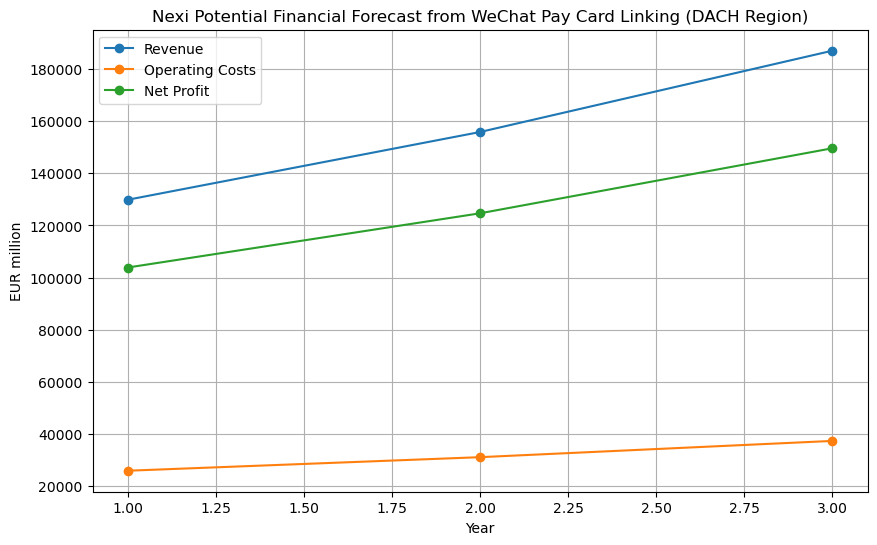

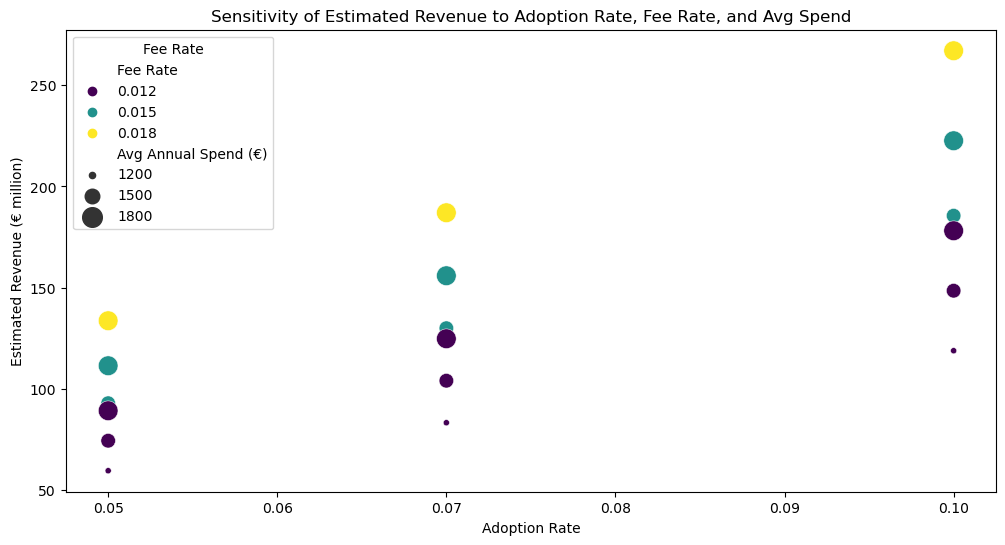

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define partner banks data
banks_data = [
    {"Bank": "Intesa Sanpaolo", "Retail_Customers_m": 14, "Cardholder_pct": 0.70},
    {"Bank": "UniCredit", "Retail_Customers_m": 25, "Cardholder_pct": 0.60},
    {"Bank": "Commerzbank", "Retail_Customers_m": 10, "Cardholder_pct": 0.65},
    {"Bank": "BNP Paribas", "Retail_Customers_m": 30, "Cardholder_pct": 0.55},
    {"Bank": "Banco Santander", "Retail_Customers_m": 20, "Cardholder_pct": 0.60},
    {"Bank": "Barclays", "Retail_Customers_m": 24, "Cardholder_pct": 0.70},
    {"Bank": "ING", "Retail_Customers_m": 9, "Cardholder_pct": 0.65},
]

banks_df = pd.DataFrame(banks_data)
# Step 2: Calculate estimated cardholders per bank
banks_df["Estimated_Cardholders_m"] = banks_df["Retail_Customers_m"] * banks_df["Cardholder_pct"]

total_cardholders_m = banks_df["Estimated_Cardholders_m"].sum()

print("Step 1 & 2: Estimated Cardholder Base by Bank (millions):")
print(banks_df[["Bank", "Estimated_Cardholders_m"]])
print(f"\nTotal Estimated Cardholders: {total_cardholders_m:.2f} million\n")

# Step 3: Estimate WeChat Pay wallet linking adoption rate
adoption_rate = 0.07  # 7% adoption
linked_cards_m = total_cardholders_m * adoption_rate
print(f"Step 3: Estimated linked cards at {adoption_rate*100}% adoption: {linked_cards_m:.2f} million\n")

# Step 4: Average transaction volume and fee assumptions
avg_annual_spend_per_card = 1500  # EUR
merchant_fee_rate = 0.015  # 1.5%

# Step 5: Calculate total transaction volume and Nexi revenue from fees
total_transaction_volume_b = linked_cards_m * avg_annual_spend_per_card  # in billion EUR
revenue_eur_m = total_transaction_volume_b * merchant_fee_rate * 1000  # convert billion to million EUR

print(f"Step 5: Total transaction volume: €{total_transaction_volume_b:.3f} billion")
print(f"Estimated Nexi Revenue from fees: €{revenue_eur_m:.2f} million\n")

# Step 6: Build dynamic financial model over 3 years with growth, costs and net profit

# Assumptions
years = 3
revenue_growth_rate = 0.20  # 20% annual growth in revenue
operating_cost_rate = 0.20  # 20% of revenue as operating costs
integration_cost_year1_m = 5  # Marketing & integration cost in million EUR (example)

# Initialize lists
revenues = []
operating_costs = []
integration_costs = []
total_costs = []
net_profits = []

for year in range(1, years + 1):
    if year == 1:
        revenue = revenue_eur_m
        integration_cost = integration_cost_year1_m
    else:
        revenue = revenues[-1] * (1 + revenue_growth_rate)
        integration_cost = 0
    
    operating_cost = revenue * operating_cost_rate
    total_cost = operating_cost + integration_cost
    net_profit = revenue - total_cost
    
    revenues.append(revenue)
    operating_costs.append(operating_cost)
    integration_costs.append(integration_cost)
    total_costs.append(total_cost)
    net_profits.append(net_profit)

financials_df = pd.DataFrame({
    "Year": range(1, years + 1),
    "Revenue (EUR million)": revenues,
    "Operating Costs (EUR million)": operating_costs,
    "Integration Cost (EUR million)": integration_costs,
    "Total Costs (EUR million)": total_costs,
    "Net Profit (EUR million)": net_profits,
})

print("Step 6: Financial Forecast over 3 Years:")
print(financials_df.round(2))

# Sensitivity analysis on adoption rate, avg transaction volume, and fee rate

adoption_rates = [0.05, 0.07, 0.10]  # 5%, 7%, 10%
avg_spends = [1200, 1500, 1800]      # EUR
fee_rates = [0.012, 0.015, 0.018]    # 1.2%, 1.5%, 1.8%

sensitivity_results = []

for a in adoption_rates:
    for s in avg_spends:
        for f in fee_rates:
            linked_cards = total_cardholders_m * a
            trans_volume = linked_cards * s
            revenue = trans_volume * f
            revenue_m = revenue  # in million EUR (since s and trans_volume are in millions/euros)
            sensitivity_results.append({
                "Adoption Rate": a,
                "Avg Annual Spend (€)": s,
                "Fee Rate": f,
                "Estimated Revenue (€ million)": revenue_m
            })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Print top 10 sensitivity scenarios sorted by revenue
print("\nSensitivity Analysis - Top 10 scenarios by estimated revenue:")
print(sensitivity_df.sort_values(by="Estimated Revenue (€ million)", ascending=False).head(10))

# Plotting the financial forecast
plt.figure(figsize=(10,6))
plt.plot(financials_df["Year"], financials_df["Revenue (EUR million)"], marker='o', label='Revenue')
plt.plot(financials_df["Year"], financials_df["Operating Costs (EUR million)"], marker='o', label='Operating Costs')
plt.plot(financials_df["Year"], financials_df["Net Profit (EUR million)"], marker='o', label='Net Profit')
plt.title("Nexi Potential Financial Forecast from WeChat Pay Card Linking (DACH Region)")
plt.xlabel("Year")
plt.ylabel("EUR million")
plt.grid(True)
plt.legend()
plt.show()

# Plot Sensitivity Analysis (3D-style visualization using seaborn heatmaps or scatter plots could be done)
plt.figure(figsize=(12,6))
sns.scatterplot(data=sensitivity_df, x="Adoption Rate", y="Estimated Revenue (€ million)", hue="Fee Rate", size="Avg Annual Spend (€)", palette="viridis", sizes=(20, 200))
plt.title("Sensitivity of Estimated Revenue to Adoption Rate, Fee Rate, and Avg Spend")
plt.xlabel("Adoption Rate")
plt.ylabel("Estimated Revenue (€ million)")
plt.legend(title="Fee Rate")
plt.show()
